# Use TrackPy for particle tracking
 #### Timothy Tyree
 #### Rappel Group
 #### July 2019

In [717]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience
import matplotlib.pyplot as plt
import pims
import trackpy as tp

from numpy import array
from scipy.sparse import csr_matrix
from PIL import Image


import matplotlib as mpl
import matplotlib.pyplot as plt
import tempfile

import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience

import pims
import trackpy as tp

from matplotlib.pyplot import quiver

import skimage
import matplotlib.patches as mpatches


# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 5))
mpl.rc('image', cmap='gray')

## Import spiral tip data

In [693]:
data_path = "../samples from FastAFSimulation2D/discrim_by_ions.csv"
maxtips = 50 #take this as an argument
rng  = list(np.arange(0,4*(maxtips)+1,1))
data = np.loadtxt(data_path, delimiter=',', skiprows=1,usecols=rng)
times = data[:,0] #index times 1 = 1ms?
ntr   = data[:,1] #number of tips: raw
a     = data[:,5:]
ap = np.reshape(a,(times.size,maxtips-1,4)) #all points: tmax by maxtips-1 by 4 array of raw spiral tip data
del a, data

In [694]:
#data is a list of all unused points for each time step
data = []
tmax = ap.shape[0]
for t in range(tmax):
    c   = (np.where(ap[t]==[0,0,0,0]))[0][0] 
    data.append(ap[t,1:c])

### [Deprecated] Put spiral tip data in a sparse matrix.

In [303]:
# mat_ifi = csr_matrix((dat_ifi, (row, col)), shape=(imgdim, imgdim)).toarray()
# mat_isi = csr_matrix((dat_isi, (row, col)), shape=(imgdim, imgdim)).toarray()
# mat_one = csr_matrix((dat_one, (row, col)), shape=(imgdim, imgdim))
# mat     = np.dstack([mat_one, mat_ifi, mat_ifi])
# #TODO: make a lookup function to avoid doing image processing on three channels

In [302]:
# img = Image.fromarray(mat, 'RGB')
# img = Image.fromarray(mat_one, 'L')
# img = Image.fromarray(mat_one, '1')
# img.show()
# imgplot = plt.imshow(mat_one)

In [301]:
# To Sparse array
# print(csr_matrix(mat_one))
# To Dense image
# print(csr_matrix(mat_one).todense())
# For matplotlib
# (imgplot.get_array().data > 0).sum()

In [696]:
# imgdim = 2*512
# frames = []
# for t in range(times.size):
#     col = imgdim*data[t][:,2] #x-coord
#     row = imgdim*data[t][:,3] #y-coord
#     if t%1000==0:
#         print(col.size)
#     dat_one = np.ones(col.size) #isi-coord
#     dat_one = (dat_one * 255).astype(np.uint8)
#     mat_one = csr_matrix((dat_one, (row, col)), shape=(imgdim, imgdim)).todense()
#     img = Image.fromarray(mat_one, 'L')
#     if t%1000==0:
#         print(csr_matrix(img.getchannel(0)).size)
#     frames.append(img)
#
# blank = csr_matrix(([], ([], [])), shape=(imgdim, imgdim)).toarray()
# imgbk = Image.fromarray(blank, '1')
# frames= np.full(times.size, imgbk)

## Put feature data into a trackpy

In [317]:
#DONE: I double checked that pixels in frames agree with the .csv file.
#DONE: I checked for and found no duplicate features.

In [340]:
#TODO: fill any metadata attributes with the .xml file of model parameters
#TODO: then, start making a parameter dependence MonteCarlo pipeline
#TODO: make velocity fields on Dicty. ML Data. https://github.com/soft-matter/trackpy-examples/blob/master/notebooks/custom-feature-detection.ipynb
#      consider using Bubble Tracking instead of Daniel's CNN (if his isn't good enough for some reason...)

In [703]:
# Assemble the feature space
tmax = len(data)
features = pd.DataFrame()
for t in range(tmax):
    feat = pd.DataFrame(data[t], columns=['ifi', 'isi', 'x', 'y'])
    fid = pd.DataFrame(np.full(data[t].shape[0] , fill_value = t), columns=['frame'])
    feat = pd.concat([fid,feat], axis=1)
    features = pd.concat([features, feat], axis=0)
dt = np.around(times[1]-times[0],decimals=1)

In [838]:
# Define distance function using pbc. 
#TODO: use this in more places to improve validity of results
def dist_pbc(pt2,pt1):
    """Returns the dist. between pt1 and pt2 given periodic boundary 
    conditions on the unit square"""
    [x1, y1] = pt1
    [x2, y2] = pt2
    dist_x = np.min([abs(x2+1-x1),abs(x2-x1),abs(x2-1-x1)])
    dist_y = np.min([abs(y2+1-y1),abs(y2-y1),abs(y2-1-y1)])
    return np.sqrt(dist_x**2 + dist_y**2)

In [875]:
# @tp.Point
# class Point(options):
# #TODO: find out how to overload the Point class so I can define a distance function that considers local ion current.


@tp.predict.predictor
def predict(t1, particle):
    """Overload the built-in predictor metric"""
    # velocity = np.array((1, -1))
    # ifi = particle['ifi']
    return particle.pos #+ velocity * (t1 - particle.t)

# pred = tp.predict.ChannelPredict(bin_size = 0.0001, flow_axis = 'ifi', minsamples=3)
pred = tp.predict.NearestVelocityPredict()

# pred = tp.predict.instrumented()(ChannelPredict)(50, flow_axis='ifi')
# tr = pd.concat(pred.link_df_iter(features, 0.5))
# trshow(tr)
# ylim(ymax=3.5);
# ?tp.predict.ChannelPredict

In [876]:
# use tp.link_df on all frames
tj = pred.link_df(features, search_range=0.05, memory=4,
               neighbor_strategy='BTree', dist_func=dist_pbc,
                 adaptive_stop=0.56, adaptive_step=0.99)
# tj = tp.link_df(features, search_range=0.05, memory=4,
#                neighbor_strategy='BTree', dist_func=dist_pbc,
#                  adaptive_stop=0.56, adaptive_step=0.99, predictor=predict)

# tj.query('particle <= 17').plot.scatter(x = 'x', y = 'y', c='particle')

Frame 1189: 28 trajectories present.


In [877]:
#TODO: classify with a local ion current predictor

#interpolate with naive linear interpolation
tj2 = pd.DataFrame()
for item in set(tj.particle):
    df   = tj.set_index('frame').query('particle=='+str(item))
    tmin = np.min(df.index.values)
    tmax = np.max(df.index.values)
    df   = df.reindex(range(tmin, tmax, 1)).interpolate()
    fms  = pd.DataFrame(df.index.values,columns=['frame'], index=range(tmin, tmax, 1))
    tms  = pd.DataFrame(times[df.index.values],columns=['times'], index=range(tmin, tmax, 1))
    #TODO: improve interpolate() to abide by periodic boundary conditions
    df2 = df.diff().fillna(0.).rename(columns={'ifi':'d_ifi', 'isi':'d_isi', 'x':'dx', 'y':'dy'}).drop(columns='particle')
    df2 = pd.concat([fms, tms, df, df2], axis=1)
    tj2 = pd.concat([tj2, df2], axis=0)
    
#TODO: add a column for the nearest particle id using dist_pbc

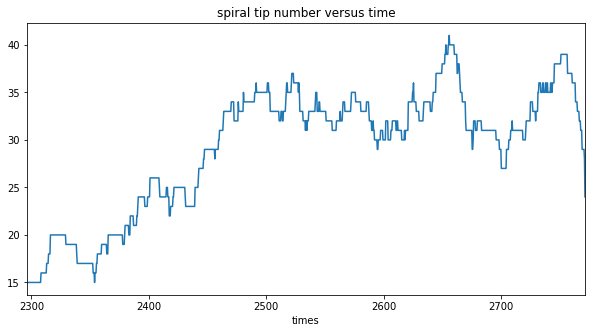

In [908]:
#filter stubs shorter than a threshold trajectory length
tj3 = tp.filter_stubs(tj2, threshold=50)
tip_number_ts = tj3.groupby(by='times').size()
tip_number_ts.plot.line(title='spiral tip number versus time')
#(tip_number_ts%2).plot.line(title='spiral tip number versus time mod 2')

#TODO: tweak tip tracking until this only has ±2
# tip_number_ts.diff().fillna(0.)


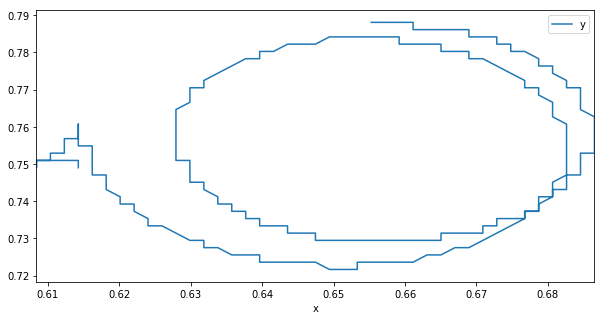

In [909]:
#TODO: if the ion current predictor isn't perfect, get tip trajectories using a predictor 
#     that penalizes points in a line that are not the furthest point in that line
#TODO: get OpenGL code to give subpixel accuracy

# tj.query('particle == 5').plot.scatter(x = 'x', y = 'y')
# tj.query('particle == 20').plot.scatter(x = 'x', y = 'y')
tj.query('particle =='+str(12)).plot.line(x = 'x', y = 'y')

In [910]:
#TODO: check all trajectories for erroneous jumps in position
# tj.query('particle == 5').shape[0]
#TODO: tweak the sorting algorithm so it doesn't jump
#TODO: build a predictor that considers observed ifi, isi trajectories
#TODO: failing ^that, build a predictor that penalizes near points (and uses adaptive search_size)
#TODO: package all this in a succinct trajectory_organizer.py
#TODO: get subpixel accuracy in input data
#TODO: communicate results with Wouter [and Patrick]
#TODO: makea trajectory_organizer for the Dicty. dispersal ML Positions
#TODO: get cv2's optical flow interface working for Dicty. motion
#TODO: get summary statistics for Dicty. cell motion
#TODO: proceed to Dispersal Figures TODO list.

#TODO: get msd of spiral tip trajectories
#TODO: get distance to nearest trajectory at time of annihilation

#TODO: try 3D tip tracking using 'ifi' as the third spatial dimension
tj3.head()

,frame,times,ifi,isi,x,y,particle,d_ifi,d_isi,dx,dy
frame,,,,,,,,,,,
0,0,2296.2,0.026988,7.019721e-08,0.893555,0.081055,0.0,0.000000,0.000000e+00,0.000000,0.000000
1,1,2296.6,0.026421,5.553756e-08,0.892904,0.080404,0.0,-0.000567,-1.465965e-08,-0.000651,-0.000651
2,2,2297.0,0.025854,4.087790e-08,0.892253,0.079753,0.0,-0.000567,-1.465965e-08,-0.000651,-0.000651
3,3,2297.4,0.025288,2.621825e-08,0.891602,0.079102,0.0,-0.000567,-1.465965e-08,-0.000651,-0.000651
4,4,2297.8,0.025123,2.318816e-08,0.891602,0.079102,0.0,-0.000165,-3.030092e-09,0.000000,0.000000


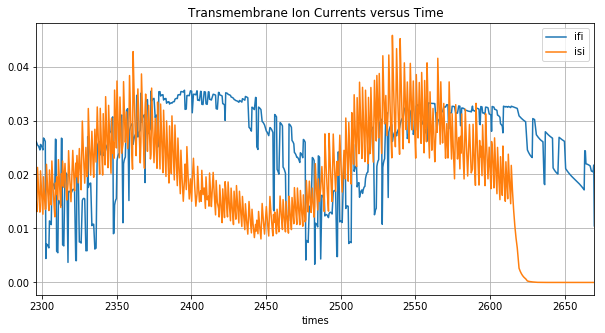

In [911]:
tj3.query('particle =='+ str(12)).plot.line(x = 'times', y = ['ifi','isi'],
                                     title='Transmembrane Ion Currents versus Time',
                                    grid=True)

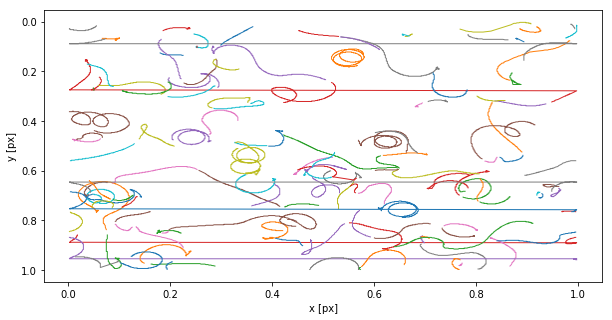

In [912]:
#TODO: see if there are any interpolated values that jump because of periodic boundary conditions
#   if ^this problem exists, find a way to correct it.
tp.plot_traj(tj3.set_index('times'))

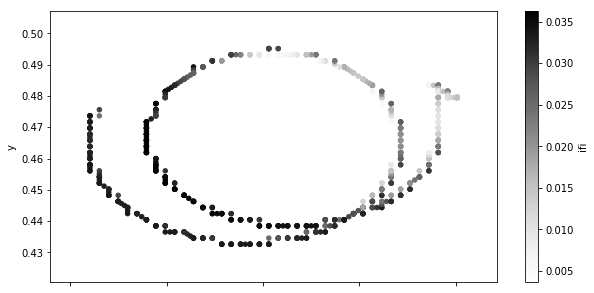

In [913]:
# tj.groupby('particle').plot.line(x='x',y='y')
# tj.query('particle == 12').plot.scatter(x = 'x', y = 'y', c='ifi')
tj3.query('particle == 5').plot.scatter(x = 'x', y = 'y', c='ifi')

# Naïve mean drift of particles

(array([39., 26., 11., 16., 11.,  7.,  8.,  3.,  4.,  1.,  2.,  1.,  0.,
         2.,  1.,  1.,  0.,  0.,  0.,  3.]),
 array([  51. ,  107.9,  164.8,  221.7,  278.6,  335.5,  392.4,  449.3,
         506.2,  563.1,  620. ,  676.9,  733.8,  790.7,  847.6,  904.5,
         961.4, 1018.3, 1075.2, 1132.1, 1189. ]),
 <a list of 20 Patch objects>)

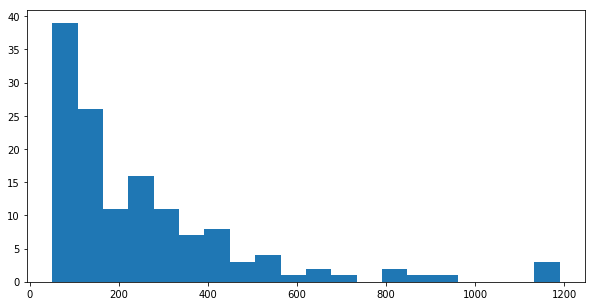

In [918]:
# 'independent' calculation of particle number as a function of time
lst_len = []
for item in set(tj3.particle):
    sub = tj3[tj3.particle==item]
    lst_len.append(len(sub))
plt.hist(lst_len, bins=20)
# Title= 'frequency of trajecory lengths'

In [922]:
#get distance to the nearest neighbor of boi
#t=0#frame
d = tp.compute_drift(tj3.set_index('times'))

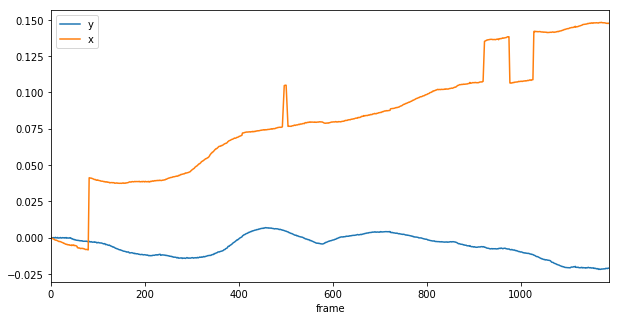

In [923]:
d.plot()
plt.show()
#Note this might be silly looking because of pbc

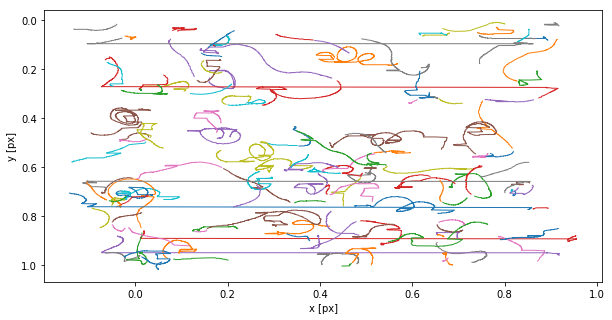

In [925]:
tm = tp.subtract_drift(tj3.copy(), d)
ax = tp.plot_traj(tm)
plt.show()
#if spiral tips were purely gaussian, these trajectories with mean drift subtracted off would look like Wiener random walks.  
# They do not look like Wiener random walks, but also there's some funny pbc stuff that needs addressed here.


### Plot of trajectories colored by fast inward current

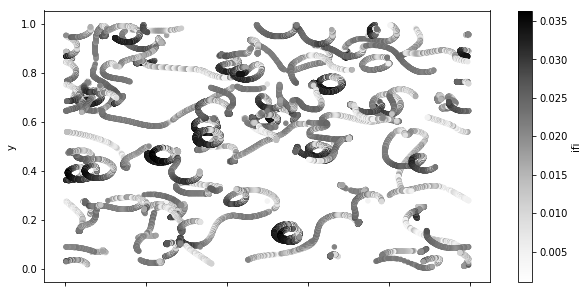

In [927]:
tj3.plot.scatter(x = 'x', y = 'y', c='ifi')

# Mean Squared Displacement of Individal Probes

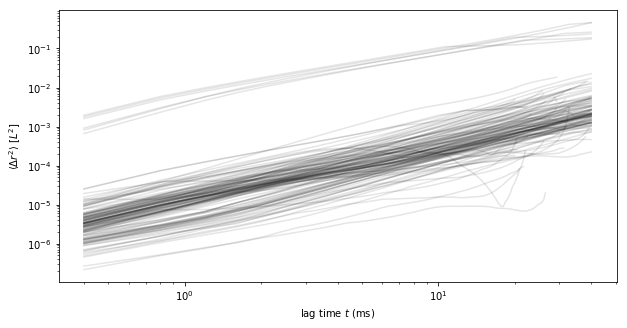

In [928]:
im = tp.imsd(tm, 1, 1/dt)  # length per pixel := unity, frames per millisecond = 1/.4
fig, ax = plt.subplots()
ax.plot(im.index, im, 'k-', alpha=0.1)  # black lines, semitransparent
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$L^2$]',
       xlabel='lag time $t$ (ms)')
ax.set_xscale('log')
ax.set_yscale('log')

# Ensemble Mean Squared Displacement

In [929]:
em = tp.emsd(tm, 1, 1/dt)  # length per pixel := unity, frames per millisecond = 1/.4

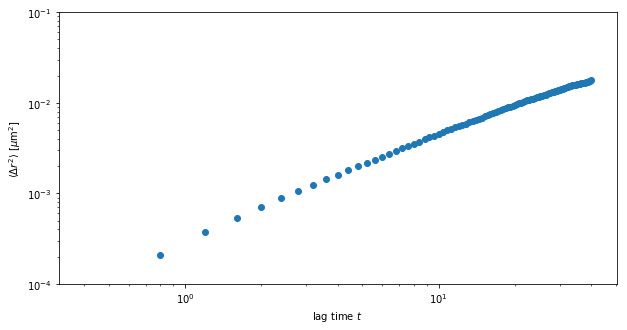

In [930]:
fig, ax = plt.subplots()
ax.plot(em.index, em, 'o')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
ax.set(ylim=(1e-4, 1e-1));

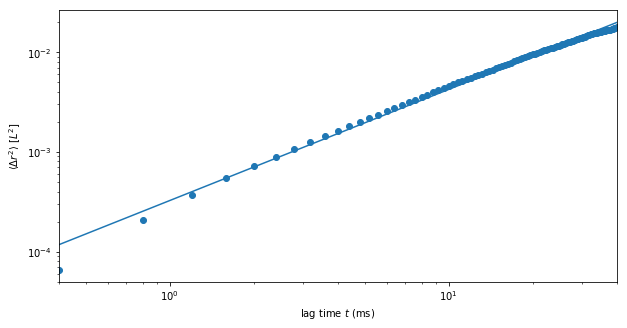

,n,A
msd,1.114559,0.000324


In [931]:
plt.figure()
plt.ylabel(r'$\langle \Delta r^2 \rangle$ [$L^2$]')
plt.xlabel('lag time $t$ (ms)');
tp.utils.fit_powerlaw(em)  # performs linear best fit in log space, plots]

In [932]:
#diffusivity is D=A/4, according to a tutorial I scooped the above section from.

# Analysis of Neighbor Proximity

In [935]:
prox = tj3.groupby('times').apply(tp.proximity).reset_index()
avg_prox = prox.groupby('particle')['proximity'].mean()

In [936]:
# particle_nos = avg_prox[avg_prox > 20].index
# tj_filtered = tj[tj['particle'].isin(particle_nos)]

In [937]:
#proximity is the distance to nearest neighbors
prox.head()

,times,particle,proximity
0,2296.2,0.0,0.127178
1,2296.2,1.0,0.304149
2,2296.2,2.0,0.127178
3,2296.2,3.0,0.290465
4,2296.2,5.0,0.194853


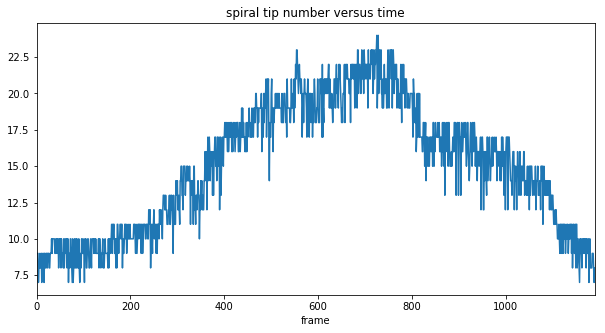

In [942]:
tip_number_ts = tp.filter_stubs(tj, threshold=300).drop(columns='frame').groupby(by='frame').size()
tip_number_ts.plot.line(title='spiral tip number versus time')

In [953]:
prox = tj3.groupby('times').apply(tp.proximity)
# pd.concat([tj3.groupby('times'), prox])

In [965]:
#I'm getting an error from the GroupBy object
# pd.concat([
pd.DataFrame(prox['proximity'], copy=True)
#            , tj3],axis=1)

proximity
times  particle           
2296.2 0.0        0.127178
       1.0        0.304149
       2.0        0.127178
       3.0        0.290465
       5.0        0.194853
       6.0        0.145845
       7.0        0.054827
       8.0        0.054827
       9.0        0.166199
       11.0       0.134028
       12.0       0.110278
       13.0       0.199458
       14.0       0.199458
       15.0       0.134028
       16.0       0.110278
2296.6 0.0        0.129623
       1.0        0.304343
       2.0        0.129623
       3.0        0.287438
       5.0        0.197613
       6.0        0.147781
       7.0        0.054722
       8.0        0.054722
       9.0        0.164248
       11.0       0.134028
       12.0       0.108482
       13.0       0.199458
       14.0       0.199458
       15.0       0.134028
       16.0       0.108482
...                    ...
2771.0 205.0      0.207620
       206.0      0.056775
       207.0      0.073418
       208.0      0.156664
       209.0      0.034939
       210.0      0.088776
2771.4 1.0        0.157817
       6.0        0.045596
       52.0       0.113281
       71.0       0.260653
       83.0       0.115301
       122.0      0.116436
       145.0      0.113281
       147.0      0.260653
       152.0      0.171742
       162.0      0.084798
       164.0      0.125381
       168.0      0.058267
       176.0      0.145439
       177.0      0.149066
       180.0      0.045596
       182.0      0.160893
       185.0      0.067686
       190.0      0.084798
       195.0      0.089076
       205.0      0.273612
       206.0      0.058267
       207.0      0.104012
       208.0      0.157817
       210.0      0.089076

[34685 rows x 1 columns]

# Export results to csv

In [967]:
tj3.to_csv(path_or_buf = 'trajectories_naive.csv')

In [971]:
tj3.query('ifi > 0.001').groupby(by='times').size()

times
2296.2    15
2296.6    15
2297.0    15
2297.4    15
2297.8    15
2298.2    15
2298.6    15
2299.0    15
2299.4    15
2299.8    15
2300.2    15
2300.6    15
2301.0    15
2301.4    15
2301.8    15
2302.2    15
2302.6    15
2303.0    15
2303.4    15
2303.8    15
2304.2    15
2304.6    15
2305.0    15
2305.4    15
2305.8    15
2306.2    15
2306.6    15
2307.0    15
2307.4    15
2307.8    15
          ..
2759.8    37
2760.2    37
2760.6    36
2761.0    36
2761.4    36
2761.8    36
2762.2    36
2762.6    36
2763.0    36
2763.4    34
2763.8    34
2764.2    34
2764.6    34
2765.0    33
2765.4    33
2765.8    33
2766.2    33
2766.6    32
2767.0    32
2767.4    32
2767.8    31
2768.2    31
2768.6    31
2769.0    29
2769.4    29
2769.8    29
2770.2    29
2770.6    29
2771.0    28
2771.4    24
Length: 1189, dtype: int64